In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

Identify which two subreddits to use for the EDA and modelling (subreddit_1 will become the target). Read in the two subreddits as separate dataframes and append them.

In [2]:
subreddit_1 = 'wallstreetbets'
subreddit_2 = 'investing'

df1 = pd.read_csv(f'../data/{subreddit_1}.csv')
df2 = pd.read_csv(f'../data/{subreddit_2}.csv')

df = df1.append(df2).reset_index()

Mapped the two subreddits to 0s and 1s for the target. Print out a statement to be clear which subreddit is the target.

In [3]:
df['sub_target'] = np.where(df['subreddit'] == df['subreddit'][0], 1, 0)
print(f"Target (1) is {df['subreddit'][0]}.")

Target (1) is wallstreetbets.


Start processing the data. Drop any duplicate posts, identified by having the same title, selftext, and author. Fill any null values in with a blank string. Combine the titles and selftexts into one string to use both in modeling.

In [4]:
df.drop_duplicates(subset=['title', 'selftext', 'author'], inplace=True)
df.fillna(' ', inplace=True)
df['combined'] = (df['title'] + ' ' + df['selftext']).str.lower()

Create a column for the character counts and word counts for each for every post.

In [5]:
df['char_count'] = df['combined'].str.len()
df['word_count'] = df['combined'].str.count(' ') + 1

Save the resulting CSV to a file for use in the modelling notebook.

In [6]:
# df.to_csv(f'../data/joined_{subreddit_1}_{subreddit_2}.csv')

Check the split between the two subreddits as percentages to ensure there is close to an even split. This is the same as the baseline accuracy which will be used in the modelling notebook.

In [7]:
df['sub_target'].value_counts(normalize=True)

1    0.504633
0    0.495367
Name: sub_target, dtype: float64

Examine the character counts for all posts to identify the mean, range, and any outliers. Considering the mean is 841 characters, there are some clear outliers with nearly 40,000 characters in the post.

In [8]:
df['char_count'].describe()

count    19858.000000
mean       841.700222
std       1408.337772
min          6.000000
25%        341.000000
50%        500.000000
75%        842.750000
max      39979.000000
Name: char_count, dtype: float64

Examine the word counts for all posts to identify the mean, range, and any outliers. Considering the mean is 137 words, there are outliers with nearly 6,000 characters in the post, similar to the character outliers.

In [9]:
df['word_count'].describe()

count    19858.000000
mean       137.330899
std        210.765588
min          2.000000
25%         58.000000
50%         86.000000
75%        141.000000
max       5955.000000
Name: word_count, dtype: float64

I created new dataframes that were filters of the data which were less than 9,000 characters and a separate dataframe with a filter for less than 1,500 words. This is for use in data visualization purposes.

In [10]:
df_char = df.loc[df['char_count'] <= 9000].copy()
df_word = df.loc[df['word_count'] <= 1500].copy()

Below I plot out the character counts, separated by subreddit. This is based on the filtered data to remove the major outliers, but still presents an extremely left skewed distribution. It is interesting to note that the two bins with the least character counts are dominated by r/wallstreetbets but almost all posts with greater character counts are dominated by r/investing. This makes sense as the wallstreetbets posts are typically shorter and less robust than the investing posts.

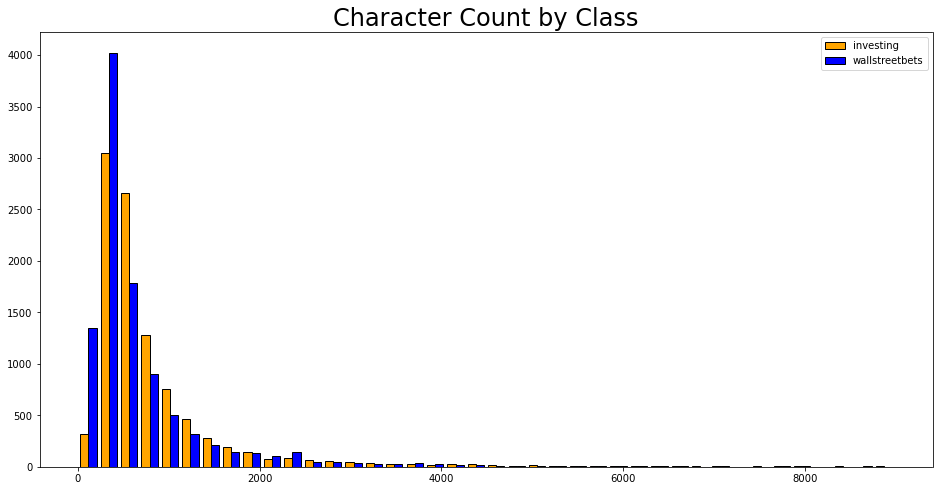

In [11]:
# Adapted from Hov's notebook code

plt.figure(figsize=(16,8))
plt.hist([df_char[df_char['sub_target']==0]['char_count'], 
          df_char[df_char['sub_target']==1]['char_count']],
         bins=40, color=['orange', 'blue'], ec='k')
plt.title('Character Count by Class', fontsize=24)
plt.legend([f'{subreddit_2}', f'{subreddit_1}']);

Below I plot out the word counts, separated by subreddit. This, too, is based on the filtered data to remove the major outliers, but still presents an extremely left skewed distribution. Similar to the findings in the character counts, the posts with the least word counts are primarily wallstreetbets posts and the higher the words, the more predominantly it becomes investing posts.

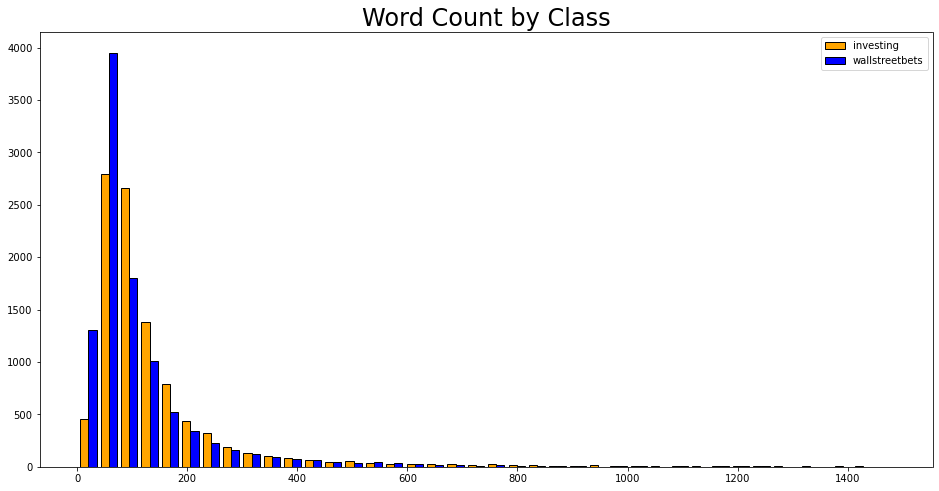

In [12]:
plt.figure(figsize=(16,8))
plt.hist([df_word[df_word['sub_target']==0]['word_count'], 
          df_word[df_word['sub_target']==1]['word_count']],
         bins=40, color=['orange', 'blue'], ec='k')
plt.title('Word Count by Class', fontsize=24)
plt.legend([f'{subreddit_2}', f'{subreddit_1}']);

Next I looked at the most commonly occuring words after removing stopwords. I set the stopwords to the default 'english' stopwords and then plotted the top ten occuring words in the training data.

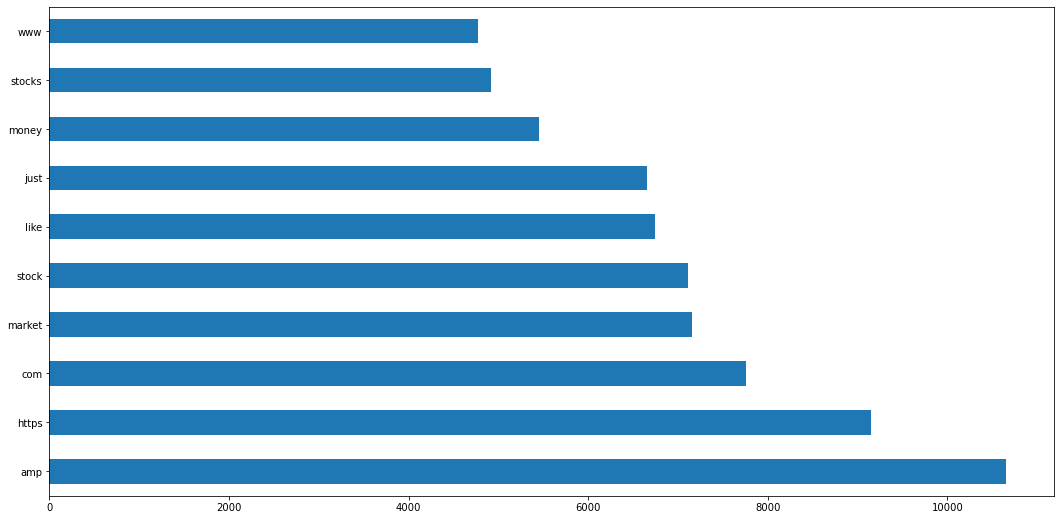

In [13]:
X = df['combined']
y = df['sub_target']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, random_state=42)

cvec = CountVectorizer(stop_words='english')

X_train = cvec.fit_transform(X_train)
X_validation = cvec.transform(X_validation)

X_train_df = pd.DataFrame(X_train.todense(), columns=cvec.get_feature_names())

plt.figure(figsize=(18, 9))
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

I also looked at the most commonly occuring bigrams after removing stopwords. I set the stopwords to the default 'english' stopwords, designated the vectorizer to only include bigrams, and then plotted the top ten occuring bigrams in the training data.

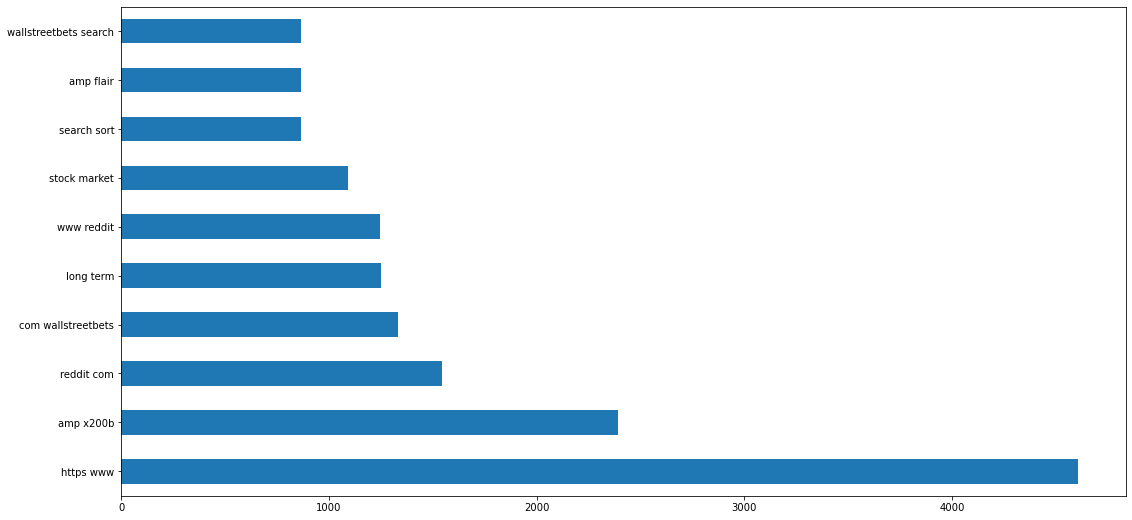

In [14]:
X = df['combined']
y = df['sub_target']

X_train_2, X_validation_2, y_train_2, y_validation_2 = train_test_split(X, y, random_state=42)

cvec = CountVectorizer(stop_words='english', ngram_range=(2,2))

X_train_2 = cvec.fit_transform(X_train_2)
X_validation_2 = cvec.transform(X_validation_2)

X_train_df_2 = pd.DataFrame(X_train_2.todense(), columns=cvec.get_feature_names())

plt.figure(figsize=(18, 9))
X_train_df_2.sum().sort_values(ascending=False).head(10).plot(kind='barh');

## Sentiment Analysis

As part of my EDA, I performed a sentiment analysis to evaluate the sentiment of each title/post combination. I decided to perform the analysis using the VADER analyzer and my own custom list of stock/investment specific sentiment terms. First, I instantiated the stemmer and loaded my stemming functions.

In [15]:
# Code help for list_stem from James Hampton

p_stemmer = PorterStemmer()

def list_stem(token_list, stemmer=p_stemmer):
    return [stemmer.stem(x) for x in token_list]

def stock_sent(stemmed):
    positive_count = sum([1 for word in stemmed if word in positive_stems])
    negative_count = sum([1 for word in stemmed if word in negative_stems])
    return (positive_count - negative_count) / len(stemmed)

Below I created my list of words that I felt represented positive or negative movements and sentiments when it comes to stocks and investing. I than ran each list through a list comprehension to stem the words, change it into a set and then back into a list to remove any duplicates.

In [16]:
positive_words = ['black', 'green', 'buy', 'bull', 'bullish', 'long', 'surplus', 'positive', 
                  'up', 'increase', 'skyrocket', 'rise', 'gain', 'gains', 'gained', 'profit', 
                  'calls', 'positive', 'happy', 'significant', 'boost', 'undervalued', 'explosive',
                  'outperform', 'jump', 'cheap', 'uptrend', 'strong', 'enter', 'higher', 'accumulate',
                  'hopeful', 'addition', 'approval', 'solid', 'upside', 'accelerate', 'better',
                  'good', 'burst', 'climb', 'over', 'breakout', 'maintain', 'opportunity', 'make', 
                  'best', 'like']

negative_words = ['red', 'sell', 'bear', 'bearish', 'short', 'shorting', 'debt', 'negative', 
                  'down', 'decrease', 'plummet', 'drop', 'lose', 'loss', 'lost', 'puts', 
                  'negative', 'risk', 'uncertain', 'worse', 'alleged', 'insignificant', 
                  'dip', 'downside', 'overvalued', 'caution', 'cautious', 'sink', 'downtrend',
                  'weak', 'dump', 'trap', 'exit', 'lower', 'divest', 'dismal', 'below', 'low',
                  'reduce', 'reduction', 'abandon', 'blood', 'bloodbath', 'bogus', 'bad', 'chump',
                  'corrupt', 'costly', 'crash', 'damage', 'danger', 'depression', 'avoid', 'under',
                  'worst', 'hate']

positive_stems = list(set([p_stemmer.stem(word) for word in positive_words]))
negative_stems = list(set([p_stemmer.stem(word) for word in negative_words]))

I instantiated the tokenizer and created tokens ir order to run the sentiment analysis. Then I mapped I then created a column of the stemmed data and then ran the analysis using my own set of positive and negative words. After that, I instantiated the SentimentIntensityAnalyzer and ran the combined data through it.

In [18]:
tokenizer = RegexpTokenizer(r'\w+')

# https://stackoverflow.com/questions/57039945/use-regexptokenizer-in-a-pandas-dataframe
df['tokens'] = df['combined'].map(tokenizer.tokenize)

df['stemmed'] = df['tokens'].map(list_stem)

df['stock_sentiment'] = df['stemmed'].map(stock_sent)

sentiment = SentimentIntensityAnalyzer()

# https://medium.com/swlh/simple-sentiment-analysis-for-nlp-beginners-and-everyone-else-using-vader-and-textblob-728da3dbe33d
df['compound_sent'] = [sentiment.polarity_scores(v)['compound'] for v in df['combined']]

Next, I translated the positive, neutral, and negative scores into labels to make it easier for plotting visualizations.

In [22]:
df['stock_sentiment_sign'] = np.where(df['stock_sentiment'] > 0, 'Positive', \
                                      (np.where(df['stock_sentiment'] < 0, 'Negative', 'Neutral')))
df['compound_sent_sign'] = np.where(df['compound_sent'] > 0, 'Positive', \
                                    (np.where(df['compound_sent'] < 0, 'Negative', 'Neutral')))

My first visualization shows an overwhelming number of posts that included 'positive' investment terms for both subreddits. There were approximately even posts with Negative investment terms or Neutral terms (indicating either an even amount of positive and negative terms or a lack of positive and negative terms altogether).

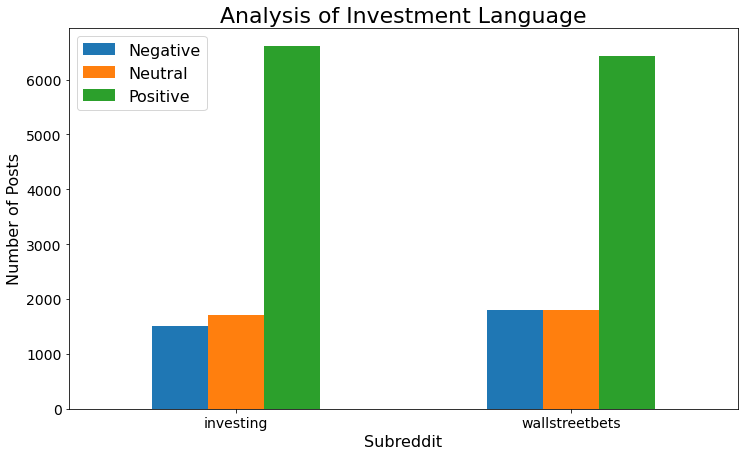

In [20]:
df.groupby(['subreddit', 'stock_sentiment_sign']).count()['index'].unstack().plot(kind='bar', figsize=(12,7))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14)
plt.xlabel('Subreddit', fontsize=16)
plt.ylabel('Number of Posts', fontsize=16)
plt.title('Analysis of Investment Language', fontsize=22);
plt.legend(loc=2, prop={'size': 16}, markerscale=5);

The second visualization showed the distribution of positive, neutral, and negative posts based on the VADER sentiment analysis. These represent the true sentiment of the posts' language as compared to specifically considering whether a post was talking about positive or negative terms with respect to investing or stocks.

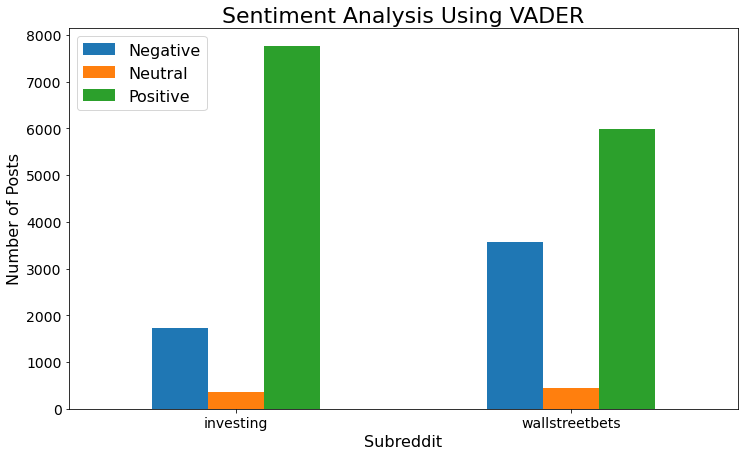

In [21]:
df.groupby(['subreddit', 'compound_sent_sign']).count()['index'].unstack().plot(kind='bar', figsize=(12,7));
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14)
plt.xlabel('Subreddit', fontsize=16)
plt.ylabel('Number of Posts', fontsize=16)
plt.title('Sentiment Analysis Using VADER', fontsize=22);
plt.legend(loc=2, prop={'size': 16}, markerscale=5);